In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
path = r"/home/perdelt/benchmarks"

In [21]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def get_performance_single(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Goodput (requests/second)': 'sum',
        'num_errors': 'sum',
        'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [4]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    # Final touches
    plt.legend(title='Type')
    plt.title(f"{title} by Number of Tenants and Type")
    plt.tight_layout()
    filename = "tpcc_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



# Container

In [22]:
codes = [
    # container
    '1750703957', #tenants=2
    '1750720553', #tenants=5
    '1750726431', #tenants 6
    '1750732553', #tenants=7
    '1750739026', #tenants=8
    '1750745725', #tenants=9
    
    # database
    '1750702209', #tenants=2
    '1750718667', #tenants=5
    '1750724506', #tenants=6
    '1750730551', #tenants=7
    '1750736861', #tenants=8
    '1750743546', #tenants=9
    
    #schema
    '1750700464', #tenants=2
    '1750716774', #tenants=5
    '1750722558', #tenants=6   
    '1750728556', #tenants=7
    '1750734762', #tenants=8
    '1750741356', #tenants=9
]

In [28]:
df_performance = get_performance_all_single(codes)
df_performance.T

connection_pod,PostgreSQL-1-1-16384-0-1-1,PostgreSQL-1-1-16384-1-1-1,PostgreSQL-1-1-16384-1-2-1,PostgreSQL-1-1-16384-0-2-1,PostgreSQL-1-1-16384-0-1-1,PostgreSQL-1-1-16384-1-1-1,PostgreSQL-1-1-16384-2-1-1,PostgreSQL-1-1-16384-3-1-1,PostgreSQL-1-1-16384-4-1-1,PostgreSQL-1-1-16384-3-2-1,...,PostgreSQL-1-1-16384-1-9,PostgreSQL-1-1-16384-2-1,PostgreSQL-1-1-16384-2-2,PostgreSQL-1-1-16384-2-3,PostgreSQL-1-1-16384-2-4,PostgreSQL-1-1-16384-2-5,PostgreSQL-1-1-16384-2-6,PostgreSQL-1-1-16384-2-7,PostgreSQL-1-1-16384-2-8,PostgreSQL-1-1-16384-2-9
connection,PostgreSQL-1-1-16384-0-1,PostgreSQL-1-1-16384-1-1,PostgreSQL-1-1-16384-1-2,PostgreSQL-1-1-16384-0-2,PostgreSQL-1-1-16384-0-1,PostgreSQL-1-1-16384-1-1,PostgreSQL-1-1-16384-2-1,PostgreSQL-1-1-16384-3-1,PostgreSQL-1-1-16384-4-1,PostgreSQL-1-1-16384-3-2,...,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2
configuration,PostgreSQL-1-1-16384-0,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-0,PostgreSQL-1-1-16384-0,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-3,PostgreSQL-1-1-16384-4,PostgreSQL-1-1-16384-3,...,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384
experiment_run,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
client,1,1,2,2,1,1,1,1,1,2,...,1,2,2,2,2,2,2,2,2,2
pod,kznc9.dbmsbenchmarker,wf2w5.dbmsbenchmarker,rz8t8.dbmsbenchmarker,6hg79.dbmsbenchmarker,dqk64.dbmsbenchmarker,g77pn.dbmsbenchmarker,hvtc4.dbmsbenchmarker,tpmtw.dbmsbenchmarker,krdq8.dbmsbenchmarker,tqtmq.dbmsbenchmarker,...,jrbdr.dbmsbenchmarker,pwlbg.dbmsbenchmarker,f9gzm.dbmsbenchmarker,zkgfb.dbmsbenchmarker,nz6tc.dbmsbenchmarker,8c249.dbmsbenchmarker,n6x9k.dbmsbenchmarker,s6j9t.dbmsbenchmarker,gq2mn.dbmsbenchmarker,xbjz6.dbmsbenchmarker
pod_count,1,1,1,1,1,1,1,1,1,1,...,9,9,9,9,9,9,9,9,9,9
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,...,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,...,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,...,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384
time,600,600,600,600,600,600,600,600,600,600,...,600,600,600,600,600,600,600,600,600,600


In [38]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

connection           configuration  \
num_tenants type                                                          
2           container  PostgreSQL-1-1-16384-0-1  PostgreSQL-1-1-16384-0   
            container  PostgreSQL-1-1-16384-1-1  PostgreSQL-1-1-16384-1   
            container  PostgreSQL-1-1-16384-1-2  PostgreSQL-1-1-16384-1   
            container  PostgreSQL-1-1-16384-0-2  PostgreSQL-1-1-16384-0   
5           container  PostgreSQL-1-1-16384-0-1  PostgreSQL-1-1-16384-0   
            container  PostgreSQL-1-1-16384-1-1  PostgreSQL-1-1-16384-1   
            container  PostgreSQL-1-1-16384-2-1  PostgreSQL-1-1-16384-2   
            container  PostgreSQL-1-1-16384-3-1  PostgreSQL-1-1-16384-3   
            container  PostgreSQL-1-1-16384-4-1  PostgreSQL-1-1-16384-4   
            container  PostgreSQL-1-1-16384-3-2  PostgreSQL-1-1-16384-3   
            container  PostgreSQL-1-1-16384-0-2  PostgreSQL-1-1-16384-0   
            container  PostgreSQL-1-1-16384-1-2  PostgreSQL-1-1-16384-1   
            container  PostgreSQL-1-1-16384-2-2  PostgreSQL-1-1-16384-2   
            container  PostgreSQL-1-1-16384-4-2  PostgreSQL-1-1-16384-4   
6           container  PostgreSQL-1-1-16384-0-1  PostgreSQL-1-1-16384-0   
            container  PostgreSQL-1-1-16384-2-1  PostgreSQL-1-1-16384-2   
            container  PostgreSQL-1-1-16384-4-1  PostgreSQL-1-1-16384-4   
            container  PostgreSQL-1-1-16384-3-1  PostgreSQL-1-1-16384-3   
            container  PostgreSQL-1-1-16384-1-1  PostgreSQL-1-1-16384-1   
            container  PostgreSQL-1-1-16384-5-1  PostgreSQL-1-1-16384-5   
            container  PostgreSQL-1-1-16384-4-2  PostgreSQL-1-1-16384-4   
            container  PostgreSQL-1-1-16384-0-2  PostgreSQL-1-1-16384-0   
            container  PostgreSQL-1-1-16384-2-2  PostgreSQL-1-1-16384-2   
            container  PostgreSQL-1-1-16384-1-2  PostgreSQL-1-1-16384-1   
            container  PostgreSQL-1-1-16384-5-2  PostgreSQL-1-1-16384-5   
            container  PostgreSQL-1-1-16384-3-2  PostgreSQL-1-1-16384-3   
7           container  PostgreSQL-1-1-16384-1-1  PostgreSQL-1-1-16384-1   
            container  PostgreSQL-1-1-16384-3-1  PostgreSQL-1-1-16384-3   
            container  PostgreSQL-1-1-16384-2-1  PostgreSQL-1-1-16384-2   
            container  PostgreSQL-1-1-16384-0-1  PostgreSQL-1-1-16384-0   
            container  PostgreSQL-1-1-16384-4-1  PostgreSQL-1-1-16384-4   
            container  PostgreSQL-1-1-16384-5-1  PostgreSQL-1-1-16384-5   
            container  PostgreSQL-1-1-16384-6-1  PostgreSQL-1-1-16384-6   
            container  PostgreSQL-1-1-16384-3-2  PostgreSQL-1-1-16384-3   
            container  PostgreSQL-1-1-16384-2-2  PostgreSQL-1-1-16384-2   
            container  PostgreSQL-1-1-16384-0-2  PostgreSQL-1-1-16384-0   
            container  PostgreSQL-1-1-16384-1-2  PostgreSQL-1-1-16384-1   
            container  PostgreSQL-1-1-16384-6-2  PostgreSQL-1-1-16384-6   
            container  PostgreSQL-1-1-16384-4-2  PostgreSQL-1-1-16384-4   
            container  PostgreSQL-1-1-16384-5-2  PostgreSQL-1-1-16384-5   
8           container  PostgreSQL-1-1-16384-5-1  PostgreSQL-1-1-16384-5   
            container  PostgreSQL-1-1-16384-7-1  PostgreSQL-1-1-16384-7   
            container  PostgreSQL-1-1-16384-0-1  PostgreSQL-1-1-16384-0   
            container  PostgreSQL-1-1-16384-2-1  PostgreSQL-1-1-16384-2   
            container  PostgreSQL-1-1-16384-3-1  PostgreSQL-1-1-16384-3   
            container  PostgreSQL-1-1-16384-4-1  PostgreSQL-1-1-16384-4   
            container  PostgreSQL-1-1-16384-6-1  PostgreSQL-1-1-16384-6   
            container  PostgreSQL-1-1-16384-1-1  PostgreSQL-1-1-16384-1   
            container  PostgreSQL-1-1-16384-6-2  PostgreSQL-1-1-16384-6   
            container  PostgreSQL-1-1-16384-3-2  PostgreSQL-1-1-16384-3   
            container  PostgreSQL-1-1-16384-7-2  PostgreSQL-1-1-16384-7   
            container  PostgreSQL-1-1-16384-5-2  PostgreSQL-1-

In [51]:
df_plot = df_performance[df_performance['client']=='1']
df_grouped = df_plot.groupby(['num_tenants', 'type']).agg({'Goodput (requests/second)':'count'})
print(df_grouped)
#for (num_tenants, typ), group_df in grouped:
#    print(f"\nGroup: num_tenants={num_tenants}, type={typ}")
#    print(group_df)


                       Goodput (requests/second)
num_tenants type                                
2           container                          2
            database                           2
            schema                             2
5           container                          5
            database                           5
            schema                             5
6           container                          6
            database                           6
            schema                             6
7           container                          7
            database                           7
            schema                             7
8           container                          8
            database                           8
            schema                             8
9           container                          9
            database                           9
            schema                             9


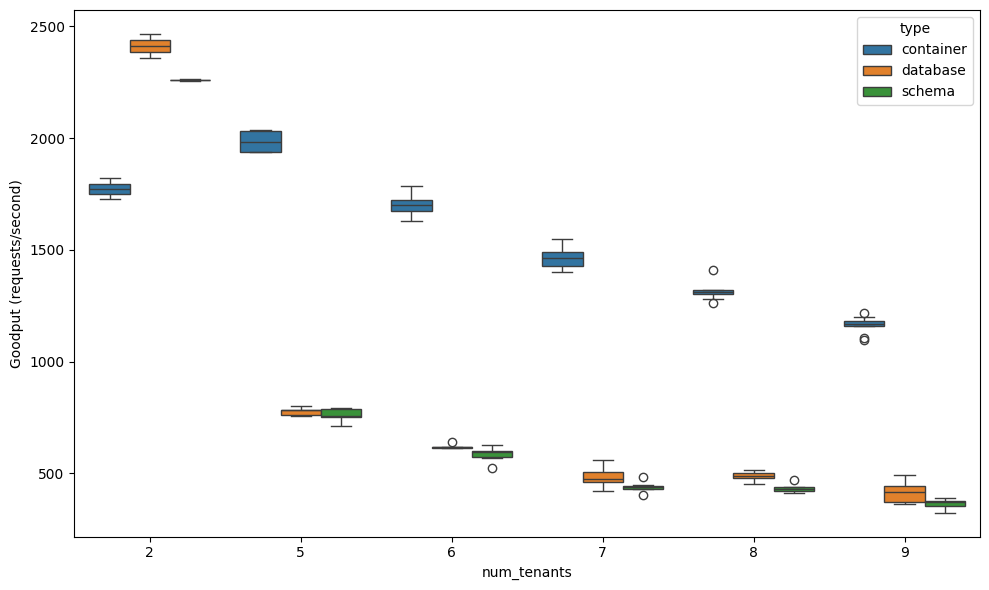

In [52]:
# Sample boxplot
df_plot = df_performance[df_performance['client']=='2']
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_plot, x="num_tenants", y="Goodput (requests/second)", hue="type")
plt.tight_layout()
plt.show()

In [23]:
df_performance = get_performance_all(codes)
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),type,num_tenants
0,1,3443.723197,37,57452.500000,container,2
1,2,3547.428217,945,54313.000000,container,2
0,1,7036.374318,108,70179.000000,container,5
1,2,9924.644833,204,49610.800000,container,5
0,1,7601.512828,109,77875.166667,container,6
1,2,10213.015541,198,57847.833333,container,6
0,1,7853.107681,96,87900.428571,container,7
1,2,10247.204332,191,67280.571429,container,7
0,1,8140.752805,115,96973.000000,container,8
1,2,10527.645679,251,74811.375000,container,8


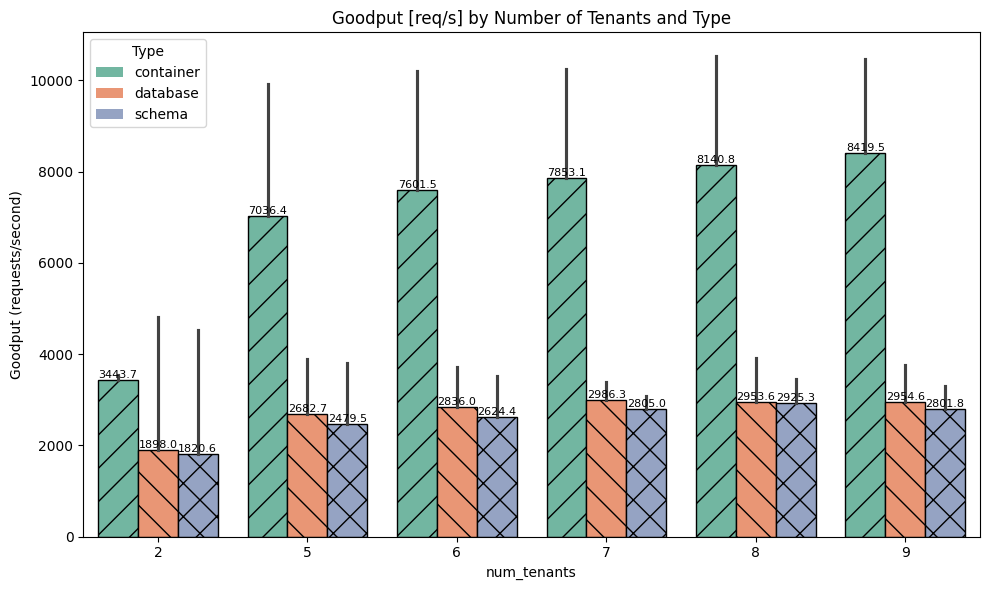

In [7]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

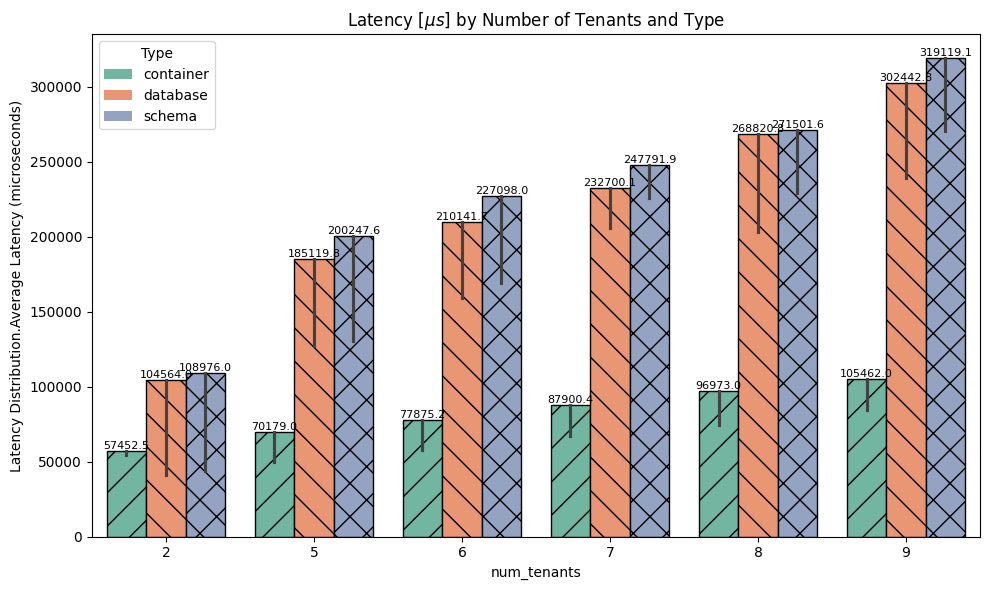

In [8]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

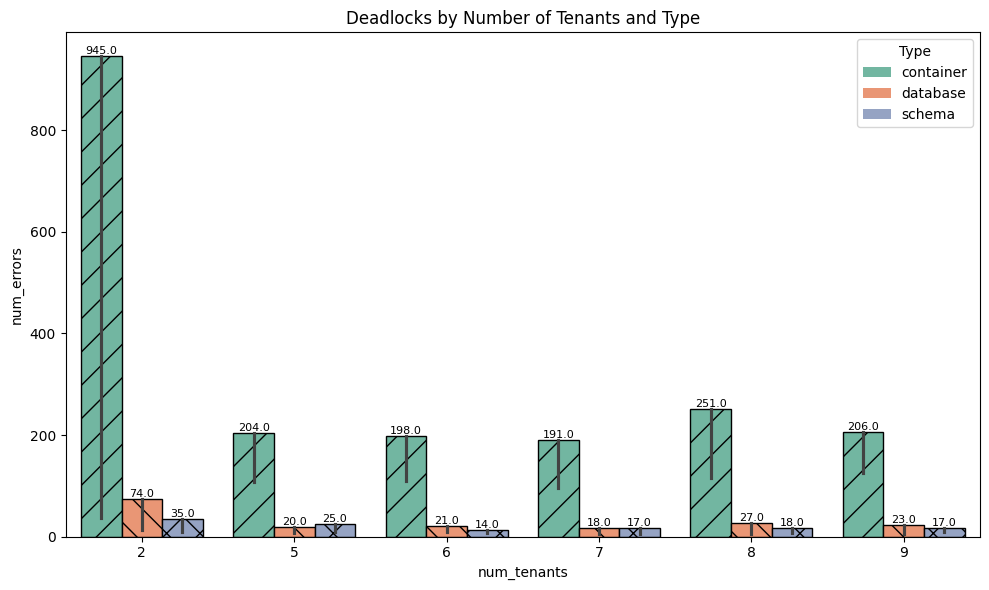

In [9]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [10]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,type,num_tenants
PostgreSQL-1-1-16384-0-1,334.0,142.0,191.0,1,1,0,1,container,2
PostgreSQL-1-1-16384-0-2,334.0,142.0,191.0,1,1,0,2,container,2
PostgreSQL-1-1-16384-1-1,275.0,117.0,158.0,1,1,1,1,container,2
PostgreSQL-1-1-16384-1-2,275.0,117.0,158.0,1,1,1,2,container,2
PostgreSQL-1-1-16384-0-1,275.0,111.0,164.0,1,1,0,1,container,5
PostgreSQL-1-1-16384-0-2,275.0,111.0,164.0,1,1,0,2,container,5
PostgreSQL-1-1-16384-1-1,277.0,111.0,165.0,1,1,1,1,container,5
PostgreSQL-1-1-16384-1-2,277.0,111.0,165.0,1,1,1,2,container,5
PostgreSQL-1-1-16384-2-1,276.0,109.0,166.0,1,1,2,1,container,5
PostgreSQL-1-1-16384-2-2,276.0,109.0,166.0,1,1,2,2,container,5


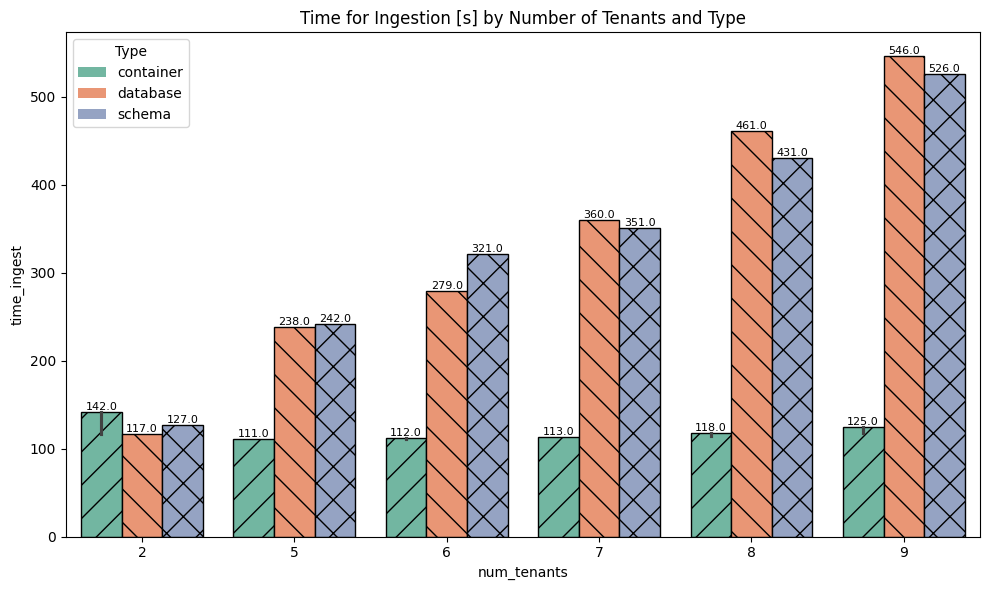

In [11]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

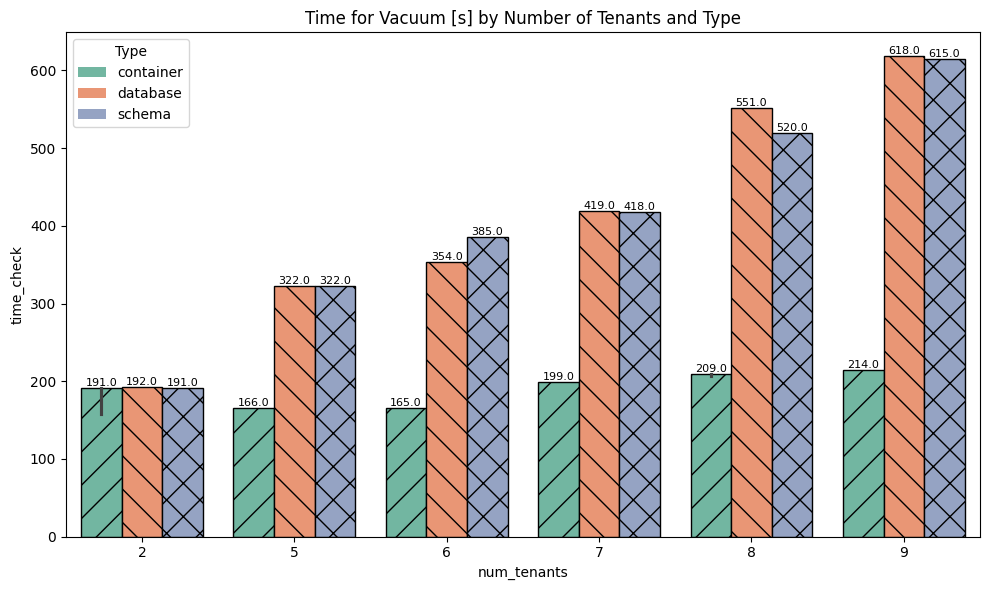

In [12]:
plot_bars(df_performance, y='time_check', title='Time for Vacuum [s]', estimator='max')

In [13]:
df_performance = get_monitoring_stream_all(codes)
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],type,num_tenants
0,1,19241.11,10.47,14.32,container,2
1,2,29514.01,12.30,17.73,container,2
0,1,33352.91,25.27,34.17,container,5
1,2,32583.21,30.61,44.07,container,5
0,1,34194.76,29.64,39.76,container,6
1,2,33125.31,35.58,50.74,container,6
0,1,34808.49,33.90,45.16,container,7
1,2,34621.62,39.68,55.85,container,7
0,1,35219.74,38.23,50.66,container,8
1,2,34941.16,44.67,62.58,container,8


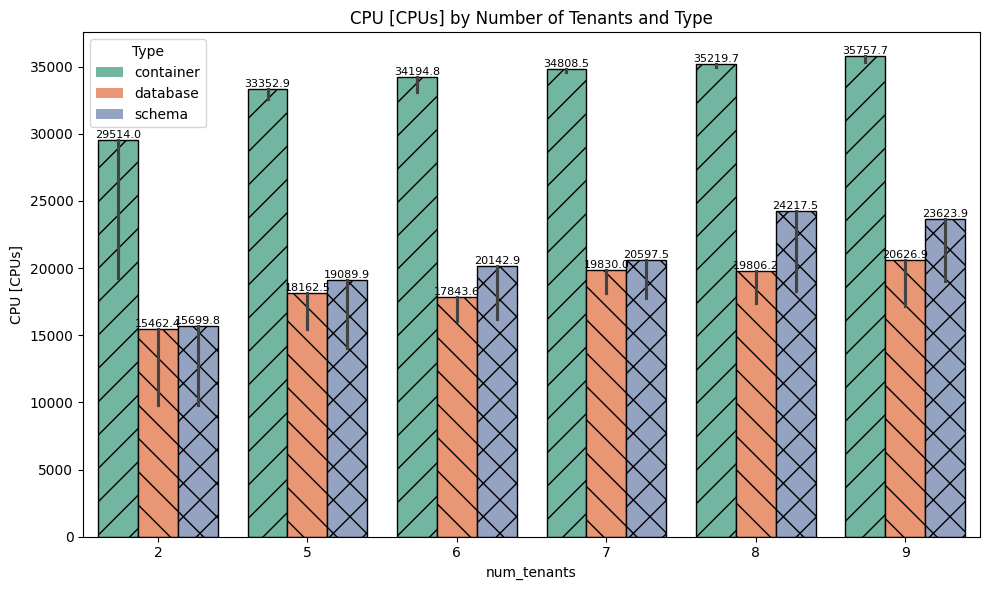

In [14]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

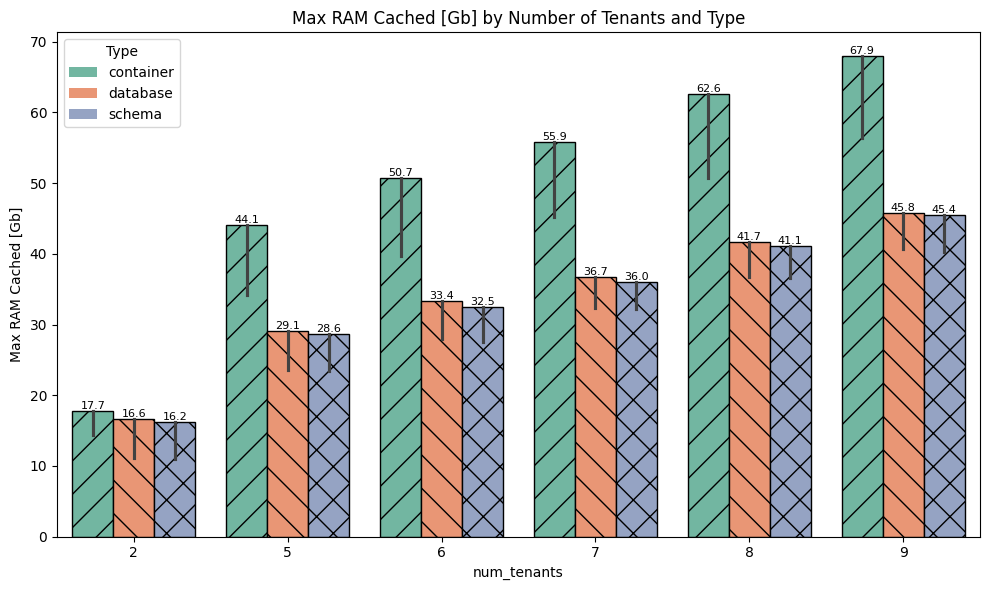

In [15]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='max')

# Single Experiment

In [16]:
code = '1750741356'
evaluation = evaluators.benchbase(code=code, path=path)
workload = get_workload(code)

In [17]:
df=get_performance_single(evaluation)
df['type']=workload['tenant_per']
df['num_tenants']=workload['num_tenants']
df.T

connection_pod,PostgreSQL-1-1-16384-1-1,PostgreSQL-1-1-16384-1-2,PostgreSQL-1-1-16384-1-3,PostgreSQL-1-1-16384-1-4,PostgreSQL-1-1-16384-1-5,PostgreSQL-1-1-16384-1-6,PostgreSQL-1-1-16384-1-7,PostgreSQL-1-1-16384-1-8,PostgreSQL-1-1-16384-1-9,PostgreSQL-1-1-16384-2-1,PostgreSQL-1-1-16384-2-2,PostgreSQL-1-1-16384-2-3,PostgreSQL-1-1-16384-2-4,PostgreSQL-1-1-16384-2-5,PostgreSQL-1-1-16384-2-6,PostgreSQL-1-1-16384-2-7,PostgreSQL-1-1-16384-2-8,PostgreSQL-1-1-16384-2-9
connection,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2
configuration,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384
experiment_run,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
client,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2
pod,v8pgd.dbmsbenchmarker,bzrfv.dbmsbenchmarker,tqj89.dbmsbenchmarker,sk5cz.dbmsbenchmarker,5whq6.dbmsbenchmarker,h4z87.dbmsbenchmarker,9l5dp.dbmsbenchmarker,tdpzd.dbmsbenchmarker,jrbdr.dbmsbenchmarker,pwlbg.dbmsbenchmarker,f9gzm.dbmsbenchmarker,zkgfb.dbmsbenchmarker,nz6tc.dbmsbenchmarker,8c249.dbmsbenchmarker,n6x9k.dbmsbenchmarker,s6j9t.dbmsbenchmarker,gq2mn.dbmsbenchmarker,xbjz6.dbmsbenchmarker
pod_count,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384
time,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600


In [18]:
get_loading_time_max(evaluation)

,time_load,time_ingest,time_check,terminals,pods,tenant,client
PostgreSQL-1-1-16384-1,1149.0,526.0,615.0,1,9,,1
PostgreSQL-1-1-16384-2,1149.0,526.0,615.0,1,9,,2


In [19]:
get_monitoring_stream_single(evaluation).sort_values('client')

,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],client
PostgreSQL-1-1-16384-1,19066.36,29.02,40.21,1
PostgreSQL-1-1-16384-2,23623.90,32.22,45.44,2


In [20]:
get_monitoring_stream(evaluation)

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb]
0,1,19066.36,29.02,40.21
1,2,23623.90,32.22,45.44
